In [68]:
import argparse
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind
from tqdm import tqdm

import torch

from scvi.inference import UnsupervisedTrainer
from scvi.models import VAE
from scvi.models.log_likelihood import compute_marginal_log_likelihood

import sys
sys.path.append('/home/oscar/scVI/ppc')
from ppc_utils import datasets_mapper, phi_mapper, compute_ks_ppc

sns.set()

# argparse
dataset_name = 'hemato'
phi_name = 'dropout'

# set hyperparameters
save_path = '/home/oscar/scVI/results/ppc_figs_bigrun_friday'
logs_path = '/home/oscar/scVI/results/ppc_logs_bigrun_friday'
n_epochs = 120
lr = 0.0004
use_batches = False
use_cuda = True
verbose = False
infer_batch_size = 32
# early_stopping_kwargs = {"early_stopping_metric": "ll"}
early_stopping_kwargs = {}
n_samples_posterior_density = 25  # 250 is scVI-reproducibility
nb_simu = 10


my_dataset = datasets_mapper[dataset_name]()
my_dataset.subsample_genes(new_n_genes=750)
dataset_name = dataset_name
phi = phi_mapper[phi_name]

nb_cells, nb_genes = my_dataset.X.shape



def corr_coeff(A, B, axis=0):
    
    sum_prod = np.sum(A*B, axis=axis)
    prod_norms = np.linalg.norm(A, axis=axis) *  np.linalg.norm(B, axis=axis)
    return sum_prod / prod_norms

def experiment_with_sigma_dropout():
    # Train models
    zi_vae = VAE(my_dataset.nb_genes, n_batch=my_dataset.n_batches * use_batches, dropout_rate=0.2,
                 reconstruction_loss='zinb')
    my_zi_trainer = UnsupervisedTrainer(zi_vae,
                                        my_dataset,
                                        train_size=0.8,
                                        use_cuda=use_cuda,
                                        kl=1, verbose=verbose, frequency=50,
                                        early_stopping_kwargs=early_stopping_kwargs)
    my_zi_trainer.train(n_epochs=n_epochs, lr=lr, eps=0.01)

    nb_vae = VAE(my_dataset.nb_genes, n_batch=my_dataset.n_batches * use_batches, dropout_rate=0.2,
                 reconstruction_loss='nb')
    my_nb_trainer = UnsupervisedTrainer(nb_vae,
                                        my_dataset,
                                        train_size=0.8,
                                        use_cuda=use_cuda, frequency=50,
                                        kl=1,
                                        early_stopping_kwargs=early_stopping_kwargs)
    my_nb_trainer.train(n_epochs=n_epochs, lr=lr, eps=0.01)

    # Generate synthetic data
    x_zi_gen, x01 = my_zi_trainer.train_set.generate(genes=None,
                                                     n_samples=n_samples_posterior_density,
                                                     zero_inflated=True,
                                                     batch_size=infer_batch_size)
    x_zi_gen = x_zi_gen.squeeze()

    x_nb_gen, x02 = my_nb_trainer.train_set.generate(genes=None,
                                                     n_samples=n_samples_posterior_density,
                                                     zero_inflated=False,
                                                     batch_size=infer_batch_size)
    x_nb_gen = x_nb_gen.squeeze()

    # Compute phi
    phi_real_gene = phi(x01, axis=0)
    phi_zi_gen_gene = phi(x_zi_gen, axis=0)
    phi_nb_gen_gene = phi(x_nb_gen, axis=0)

    print(phi_real_gene.shape, phi_zi_gen_gene.shape)
    
    # Compute imputations

    
    full_zi = my_zi_trainer.create_posterior(my_zi_trainer.model, my_dataset, indices=np.arange(len(my_dataset)))
    
    full_nb = my_zi_trainer.create_posterior(my_nb_trainer.model, my_dataset, indices=np.arange(len(my_dataset)))

    # Get dropouts
    imp_scales_zi = []
    imp_scales_nb = []
    imp_dropouts_zi = []
    imp_dropouts_nb = []
    with torch.no_grad():
        for tensors in full_zi.sequential():
            sample_batch, _, _, batch_index, labels = tensors
            px_scale_zi, _, _, px_dropout_zi = my_zi_trainer.model.inference(sample_batch, batch_index=batch_index, n_samples=1)[:4]
            imp_scales_zi += [np.array(px_scale_zi.cpu())]
            imp_dropouts_zi += [np.array(px_dropout_zi.cpu())]
        for tensors in full_nb.sequential():
            sample_batch, _, _, batch_index, labels = tensors
            px_scale_nb, _, _, px_dropout_nb = my_nb_trainer.model.inference(sample_batch, batch_index=batch_index, n_samples=1)[:4]
            imp_scales_nb += [np.array(px_scale_nb.cpu())]
            imp_dropouts_nb += [np.array(px_dropout_nb.cpu())]
            
            
    
            
    imp_scales_zi = np.concatenate(imp_scales_zi)
    imp_scales_nb = np.concatenate(imp_scales_nb)
            
    imp_dropouts_zi = np.concatenate(imp_dropouts_zi)
    imp_dropouts_nb = np.concatenate(imp_dropouts_nb)
    
    
    diff_gene_exp_mean_zi = np.abs(my_dataset.X - imp_scales_zi)
    diff_gene_exp_mean_zi_median = np.median(diff_gene_exp_mean_zi, axis=0)
    diff_gene_exp_mean_zi_mean = np.mean(diff_gene_exp_mean_zi, axis=0)
    
    diff_gene_exp_mean_nb = np.abs(my_dataset.X - imp_scales_nb)
    diff_gene_exp_mean_nb_median = np.median(diff_gene_exp_mean_nb, axis=0)
    diff_gene_exp_mean_nb_mean = np.mean(diff_gene_exp_mean_nb, axis=0)
    
    dropout_zi_min = imp_dropouts_zi.min(axis=0)
    dropout_zi_max = imp_dropouts_zi.max(axis=0)
    dropout_zi_mean = imp_dropouts_zi.mean(axis=0)
    dropout_zi_std = imp_dropouts_zi.std(axis=0)
    
    dropout_nb_min = imp_dropouts_nb.min(axis=0)
    dropout_nb_max = imp_dropouts_nb.max(axis=0)
    dropout_nb_mean = imp_dropouts_nb.mean(axis=0)
    dropout_nb_std = imp_dropouts_nb.std(axis=0)
    
    corr_diff_gene_exp_mean_dropout_zi = corr_coeff(diff_gene_exp_mean_zi_mean, imp_dropouts_zi,axis=0)
    corr_diff_gene_exp_mean_dropout_nb = corr_coeff(diff_gene_exp_mean_nb_mean, imp_dropouts_nb,axis=0)
    
    

    assert len(phi_real_gene) == nb_genes
    assert len(diff_gene_exp_mean_nb_mean) == nb_genes
    assert len(corr_diff_gene_exp_mean_dropout_nb) == nb_genes
    return (phi_zi_gen_gene, phi_nb_gen_gene, phi_real_gene,
            diff_gene_exp_mean_zi_median, diff_gene_exp_mean_zi_mean, corr_diff_gene_exp_mean_dropout_zi,
            diff_gene_exp_mean_nb_median, diff_gene_exp_mean_nb_mean, corr_diff_gene_exp_mean_dropout_nb,
            dropout_zi_min, dropout_zi_max, dropout_zi_mean, dropout_zi_std,
            dropout_nb_min, dropout_nb_max, dropout_nb_mean, dropout_nb_std)
           

File data/HEMATO/bBM.raw_umifm_counts.csv.gz already downloaded
File data/HEMATO/data.zip already downloaded
Preprocessing Hemato data
Finished preprocessing Hemato data
Downsampling from 7397 to 750 genes
Downsampling from 4016 to 4016 cells


In [69]:
corr_coeff(np.ones((3, 5)), 2*np.ones((3,5))).shape

(5,)

# Computing genes' statistics

The objective of this section is to compute gene-specific statistics that reflect whether the observed number of zeros is matching reality

In [71]:
ts_zi = []
ts_nb = []
diff_gene_exp_mean_zi_medians = []
diff_gene_exp_mean_zi_means = []
corrs_diff_gene_exp_mean_dropout_zi = []
diff_gene_exp_mean_nb_medians = []
diff_gene_exp_mean_nb_means = []
corrs_diff_gene_exp_mean_dropout_nb = []
dropout_zi_mins = []
dropout_zi_maxs = []
dropout_zi_means = []
dropout_zi_stds = []
dropout_nb_mins = []
dropout_nb_maxs = []
dropout_nb_means = []
dropout_nb_stds = []


for _ in tqdm(range(nb_simu)):
    
    (phi_zi_gen_gene, phi_nb_gen_gene, phi_real_gene,
     diff_gene_exp_mean_zi_median, diff_gene_exp_mean_zi_mean, corr_diff_gene_exp_mean_dropout_zi,
     diff_gene_exp_mean_nb_median, diff_gene_exp_mean_nb_mean, corr_diff_gene_exp_mean_dropout_nb,
     dropout_zi_min, dropout_zi_max, dropout_zi_mean, dropout_zi_std,
     dropout_nb_min, dropout_nb_max, dropout_nb_mean, dropout_nb_std) = experiment_with_sigma_dropout()
    
    se_zi = phi_zi_gen_gene.std(axis=-1) / np.sqrt(nb_cells)
    se_nb = phi_nb_gen_gene.std(axis=-1) / np.sqrt(nb_cells)
    t_zi = (phi_zi_gen_gene.mean(axis=-1) - phi_real_gene) / se_zi
    t_nb = (phi_nb_gen_gene.mean(axis=-1) - phi_real_gene) / se_nb
    
    diff_gene_exp_mean_zi_medians.append(diff_gene_exp_mean_zi_median)
    diff_gene_exp_mean_zi_means.append(diff_gene_exp_mean_zi_mean)
    corrs_diff_gene_exp_mean_dropout_zi.append(corr_diff_gene_exp_mean_dropout_zi)
    diff_gene_exp_mean_nb_medians.append(diff_gene_exp_mean_nb_median)
    diff_gene_exp_mean_nb_means.append(diff_gene_exp_mean_nb_mean)
    corrs_diff_gene_exp_mean_dropout_nb.append(corr_diff_gene_exp_mean_dropout_nb)
    
    ts_zi.append(t_zi)
    ts_nb.append(t_nb)
    
    dropout_zi_mins.append(dropout_zi_min)
    dropout_zi_maxs.append(dropout_zi_max)
    dropout_zi_means.append(dropout_zi_mean)
    dropout_zi_stds.append(dropout_zi_std)
    
    dropout_nb_mins.append(dropout_nb_min)
    dropout_nb_maxs.append(dropout_nb_max)
    dropout_nb_means.append(dropout_nb_mean)
    dropout_nb_stds.append(dropout_nb_std)

ts_zi = np.array(ts_zi)
ts_nb = np.array(ts_nb)

print(ts_zi.shape)



  0%|          | 0/10 [00:00<?, ?it/s]




training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:19,  6.20it/s]


training:   2%|▏         | 2/120 [00:00<00:19,  6.19it/s]


training:   2%|▎         | 3/120 [00:00<00:19,  6.01it/s]


training:   3%|▎         | 4/120 [00:00<00:20,  5.78it/s]


training:   4%|▍         | 5/120 [00:00<00:19,  5.90it/s]


training:   5%|▌         | 6/120 [00:01<00:19,  5.97it/s]


training:   6%|▌         | 7/120 [00:01<00:19,  5.94it/s]


training:   7%|▋         | 8/120 [00:01<00:19,  5.84it/s]


training:   8%|▊         | 9/120 [00:01<00:19,  5.77it/s]


training:   8%|▊         | 10/120 [00:01<00:18,  5.87it/s]


training:   9%|▉         | 11/120 [00:01<00:18,  5.78it/s]


training:  10%|█         | 12/120 [00:02<00:18,  5.89it/s]


training:  11%|█         | 13/120 [00:02<00:17,  5.97it/s]


training:  12%|█▏        | 14/120 [00:02<00:17,  6.01it/s]


training:  12%|█▎        | 15/120 [00:02<00:17,  6.10it/s]


training:  13%|█▎        | 16/120 [00:0

training:  98%|█████████▊| 117/120 [00:19<00:00,  5.89it/s]


training:  98%|█████████▊| 118/120 [00:19<00:00,  5.69it/s]


training:  99%|█████████▉| 119/120 [00:20<00:00,  5.73it/s]


training: 100%|██████████| 120/120 [00:20<00:00,  5.01it/s]


training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:20,  5.78it/s]


training:   2%|▏         | 2/120 [00:00<00:19,  5.93it/s]


training:   2%|▎         | 3/120 [00:00<00:19,  6.06it/s]


training:   3%|▎         | 4/120 [00:00<00:18,  6.17it/s]


training:   4%|▍         | 5/120 [00:00<00:18,  6.30it/s]


training:   5%|▌         | 6/120 [00:00<00:17,  6.40it/s]


training:   6%|▌         | 7/120 [00:01<00:17,  6.42it/s]


training:   7%|▋         | 8/120 [00:01<00:17,  6.44it/s]


training:   8%|▊         | 9/120 [00:01<00:17,  6.49it/s]


training:   8%|▊         | 10/120 [00:01<00:16,  6.55it/s]


training:   9%|▉         | 11/120 [00:01<00:16,  6.59it/s]


training:  10%|█         | 12/120 [00:

training:  94%|█████████▍| 113/120 [00:17<00:01,  6.71it/s]


training:  95%|█████████▌| 114/120 [00:17<00:00,  6.74it/s]


training:  96%|█████████▌| 115/120 [00:18<00:00,  6.76it/s]


training:  97%|█████████▋| 116/120 [00:18<00:00,  6.75it/s]


training:  98%|█████████▊| 117/120 [00:18<00:00,  6.78it/s]


training:  98%|█████████▊| 118/120 [00:18<00:00,  6.79it/s]


training:  99%|█████████▉| 119/120 [00:18<00:00,  6.79it/s]


training: 100%|██████████| 120/120 [00:18<00:00,  5.95it/s](750,) (750, 25)




 10%|█         | 1/10 [00:41<06:16, 41.85s/it]




training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:20,  5.93it/s]


training:   2%|▏         | 2/120 [00:00<00:19,  6.00it/s]


training:   2%|▎         | 3/120 [00:00<00:19,  6.06it/s]


training:   3%|▎         | 4/120 [00:00<00:19,  6.09it/s]


training:   4%|▍         | 5/120 [00:00<00:18,  6.10it/s]


training:   5%|▌         | 6/120 [00:00<00:18,  6.13it/s]


training:   6%|▌         | 7/120 [00:01<00:18,  6.14it/s]


training:   7%|▋         | 8/120 [00:01<00:18,  6.15it/s]


training:   8%|▊         | 9/120 [00:01<00:17,  6.18it/s]


training:   8%|▊         | 10/120 [00:01<00:17,  6.19it/s]


training:   9%|▉         | 11/120 [00:01<00:17,  6.18it/s]


training:  10%|█         | 12/120 [00:01<00:17,  6.20it/s]


training:  11%|█         | 13/120 [00:02<00:17,  6.09it/s]


training:  12%|█▏        | 14/120 [00:02<00:17,  6.00it/s]


training:  12%|█▎        | 15/120 [00:02<00:17,  5.92it/s]


training:  13%|█▎        | 16/120 [00:0

training:  98%|█████████▊| 117/120 [00:19<00:00,  5.83it/s]


training:  98%|█████████▊| 118/120 [00:19<00:00,  5.77it/s]


training:  99%|█████████▉| 119/120 [00:19<00:00,  5.78it/s]


training: 100%|██████████| 120/120 [00:20<00:00,  5.26it/s]


training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:17,  6.86it/s]


training:   2%|▏         | 2/120 [00:00<00:17,  6.66it/s]


training:   2%|▎         | 3/120 [00:00<00:18,  6.48it/s]


training:   3%|▎         | 4/120 [00:00<00:17,  6.59it/s]


training:   4%|▍         | 5/120 [00:00<00:17,  6.66it/s]


training:   5%|▌         | 6/120 [00:00<00:16,  6.73it/s]


training:   6%|▌         | 7/120 [00:01<00:16,  6.79it/s]


training:   7%|▋         | 8/120 [00:01<00:16,  6.65it/s]


training:   8%|▊         | 9/120 [00:01<00:16,  6.63it/s]


training:   8%|▊         | 10/120 [00:01<00:16,  6.64it/s]


training:   9%|▉         | 11/120 [00:01<00:16,  6.72it/s]


training:  10%|█         | 12/120 [00:

training:  94%|█████████▍| 113/120 [00:16<00:01,  6.94it/s]


training:  95%|█████████▌| 114/120 [00:16<00:00,  6.96it/s]


training:  96%|█████████▌| 115/120 [00:16<00:00,  6.89it/s]


training:  97%|█████████▋| 116/120 [00:17<00:00,  6.90it/s]


training:  98%|█████████▊| 117/120 [00:17<00:00,  6.96it/s]


training:  98%|█████████▊| 118/120 [00:17<00:00,  6.99it/s]


training:  99%|█████████▉| 119/120 [00:17<00:00,  7.02it/s]


training: 100%|██████████| 120/120 [00:17<00:00,  6.12it/s](750,) (750, 25)




 20%|██        | 2/10 [01:22<05:31, 41.45s/it]




training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:20,  5.86it/s]


training:   2%|▏         | 2/120 [00:00<00:19,  5.97it/s]


training:   2%|▎         | 3/120 [00:00<00:19,  6.06it/s]


training:   3%|▎         | 4/120 [00:00<00:18,  6.11it/s]


training:   4%|▍         | 5/120 [00:00<00:18,  6.14it/s]


training:   5%|▌         | 6/120 [00:00<00:18,  6.15it/s]


training:   6%|▌         | 7/120 [00:01<00:18,  6.13it/s]


training:   7%|▋         | 8/120 [00:01<00:18,  6.15it/s]


training:   8%|▊         | 9/120 [00:01<00:17,  6.19it/s]


training:   8%|▊         | 10/120 [00:01<00:17,  6.21it/s]


training:   9%|▉         | 11/120 [00:01<00:17,  6.22it/s]


training:  10%|█         | 12/120 [00:01<00:17,  6.22it/s]


training:  11%|█         | 13/120 [00:02<00:17,  6.23it/s]


training:  12%|█▏        | 14/120 [00:02<00:17,  6.20it/s]


training:  12%|█▎        | 15/120 [00:02<00:16,  6.21it/s]


training:  13%|█▎        | 16/120 [00:0

training:  98%|█████████▊| 117/120 [00:18<00:00,  6.27it/s]


training:  98%|█████████▊| 118/120 [00:18<00:00,  6.28it/s]


training:  99%|█████████▉| 119/120 [00:19<00:00,  6.28it/s]


training: 100%|██████████| 120/120 [00:19<00:00,  5.50it/s]


training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:17,  6.87it/s]


training:   2%|▏         | 2/120 [00:00<00:17,  6.87it/s]


training:   2%|▎         | 3/120 [00:00<00:17,  6.87it/s]


training:   3%|▎         | 4/120 [00:00<00:16,  6.85it/s]


training:   4%|▍         | 5/120 [00:00<00:16,  6.85it/s]


training:   5%|▌         | 6/120 [00:00<00:16,  6.81it/s]


training:   6%|▌         | 7/120 [00:01<00:16,  6.81it/s]


training:   7%|▋         | 8/120 [00:01<00:16,  6.79it/s]


training:   8%|▊         | 9/120 [00:01<00:16,  6.80it/s]


training:   8%|▊         | 10/120 [00:01<00:16,  6.81it/s]


training:   9%|▉         | 11/120 [00:01<00:16,  6.80it/s]


training:  10%|█         | 12/120 [00:

training:  94%|█████████▍| 113/120 [00:16<00:01,  6.88it/s]


training:  95%|█████████▌| 114/120 [00:16<00:00,  6.90it/s]


training:  96%|█████████▌| 115/120 [00:17<00:00,  6.87it/s]


training:  97%|█████████▋| 116/120 [00:17<00:00,  6.86it/s]


training:  98%|█████████▊| 117/120 [00:17<00:00,  6.85it/s]


training:  98%|█████████▊| 118/120 [00:17<00:00,  6.85it/s]


training:  99%|█████████▉| 119/120 [00:17<00:00,  6.84it/s]


training: 100%|██████████| 120/120 [00:17<00:00,  5.94it/s](750,) (750, 25)




 30%|███       | 3/10 [02:02<04:46, 40.95s/it]




training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:20,  5.78it/s]


training:   2%|▏         | 2/120 [00:00<00:20,  5.85it/s]


training:   2%|▎         | 3/120 [00:00<00:19,  5.96it/s]


training:   3%|▎         | 4/120 [00:00<00:19,  6.05it/s]


training:   4%|▍         | 5/120 [00:00<00:18,  6.11it/s]


training:   5%|▌         | 6/120 [00:00<00:18,  6.13it/s]


training:   6%|▌         | 7/120 [00:01<00:18,  6.17it/s]


training:   7%|▋         | 8/120 [00:01<00:18,  6.19it/s]


training:   8%|▊         | 9/120 [00:01<00:17,  6.19it/s]


training:   8%|▊         | 10/120 [00:01<00:17,  6.22it/s]


training:   9%|▉         | 11/120 [00:01<00:17,  6.24it/s]


training:  10%|█         | 12/120 [00:01<00:17,  6.24it/s]


training:  11%|█         | 13/120 [00:02<00:17,  6.22it/s]


training:  12%|█▏        | 14/120 [00:02<00:17,  6.23it/s]


training:  12%|█▎        | 15/120 [00:02<00:16,  6.25it/s]


training:  13%|█▎        | 16/120 [00:0

training:  98%|█████████▊| 117/120 [00:18<00:00,  6.26it/s]


training:  98%|█████████▊| 118/120 [00:19<00:00,  6.27it/s]


training:  99%|█████████▉| 119/120 [00:19<00:00,  6.24it/s]


training: 100%|██████████| 120/120 [00:19<00:00,  5.45it/s]


training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:17,  6.61it/s]


training:   2%|▏         | 2/120 [00:00<00:17,  6.64it/s]


training:   2%|▎         | 3/120 [00:00<00:17,  6.68it/s]


training:   3%|▎         | 4/120 [00:00<00:17,  6.72it/s]


training:   4%|▍         | 5/120 [00:00<00:17,  6.75it/s]


training:   5%|▌         | 6/120 [00:00<00:16,  6.73it/s]


training:   6%|▌         | 7/120 [00:01<00:16,  6.75it/s]


training:   7%|▋         | 8/120 [00:01<00:16,  6.75it/s]


training:   8%|▊         | 9/120 [00:01<00:16,  6.76it/s]


training:   8%|▊         | 10/120 [00:01<00:16,  6.76it/s]


training:   9%|▉         | 11/120 [00:01<00:16,  6.76it/s]


training:  10%|█         | 12/120 [00:

training:  94%|█████████▍| 113/120 [00:16<00:01,  6.62it/s]


training:  95%|█████████▌| 114/120 [00:17<00:00,  6.60it/s]


training:  96%|█████████▌| 115/120 [00:17<00:00,  6.60it/s]


training:  97%|█████████▋| 116/120 [00:17<00:00,  6.62it/s]


training:  98%|█████████▊| 117/120 [00:17<00:00,  6.60it/s]


training:  98%|█████████▊| 118/120 [00:17<00:00,  6.61it/s]


training:  99%|█████████▉| 119/120 [00:17<00:00,  6.61it/s]


training: 100%|██████████| 120/120 [00:18<00:00,  5.80it/s](750,) (750, 25)




 40%|████      | 4/10 [02:42<04:04, 40.68s/it]




training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:20,  5.74it/s]


training:   2%|▏         | 2/120 [00:00<00:20,  5.81it/s]


training:   2%|▎         | 3/120 [00:00<00:19,  5.85it/s]


training:   3%|▎         | 4/120 [00:00<00:19,  5.91it/s]


training:   4%|▍         | 5/120 [00:00<00:19,  5.95it/s]


training:   5%|▌         | 6/120 [00:01<00:19,  5.99it/s]


training:   6%|▌         | 7/120 [00:01<00:18,  6.03it/s]


training:   7%|▋         | 8/120 [00:01<00:18,  6.05it/s]


training:   8%|▊         | 9/120 [00:01<00:18,  6.06it/s]


training:   8%|▊         | 10/120 [00:01<00:18,  6.07it/s]


training:   9%|▉         | 11/120 [00:01<00:17,  6.07it/s]


training:  10%|█         | 12/120 [00:01<00:17,  6.07it/s]


training:  11%|█         | 13/120 [00:02<00:17,  6.09it/s]


training:  12%|█▏        | 14/120 [00:02<00:17,  6.10it/s]


training:  12%|█▎        | 15/120 [00:02<00:17,  6.09it/s]


training:  13%|█▎        | 16/120 [00:0

training:  98%|█████████▊| 117/120 [00:18<00:00,  6.30it/s]


training:  98%|█████████▊| 118/120 [00:19<00:00,  6.29it/s]


training:  99%|█████████▉| 119/120 [00:19<00:00,  6.26it/s]


training: 100%|██████████| 120/120 [00:19<00:00,  5.49it/s]


training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:17,  6.87it/s]


training:   2%|▏         | 2/120 [00:00<00:17,  6.85it/s]


training:   2%|▎         | 3/120 [00:00<00:17,  6.86it/s]


training:   3%|▎         | 4/120 [00:00<00:16,  6.86it/s]


training:   4%|▍         | 5/120 [00:00<00:16,  6.85it/s]


training:   5%|▌         | 6/120 [00:00<00:16,  6.82it/s]


training:   6%|▌         | 7/120 [00:01<00:16,  6.82it/s]


training:   7%|▋         | 8/120 [00:01<00:16,  6.80it/s]


training:   8%|▊         | 9/120 [00:01<00:16,  6.79it/s]


training:   8%|▊         | 10/120 [00:01<00:16,  6.79it/s]


training:   9%|▉         | 11/120 [00:01<00:16,  6.79it/s]


training:  10%|█         | 12/120 [00:

training:  94%|█████████▍| 113/120 [00:16<00:01,  6.89it/s]


training:  95%|█████████▌| 114/120 [00:16<00:00,  6.91it/s]


training:  96%|█████████▌| 115/120 [00:17<00:00,  6.89it/s]


training:  97%|█████████▋| 116/120 [00:17<00:00,  6.87it/s]


training:  98%|█████████▊| 117/120 [00:17<00:00,  6.84it/s]


training:  98%|█████████▊| 118/120 [00:17<00:00,  6.80it/s]


training:  99%|█████████▉| 119/120 [00:17<00:00,  6.78it/s]


training: 100%|██████████| 120/120 [00:17<00:00,  5.94it/s](750,) (750, 25)




 50%|█████     | 5/10 [03:22<03:22, 40.46s/it]




training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:20,  5.93it/s]


training:   2%|▏         | 2/120 [00:00<00:19,  5.99it/s]


training:   2%|▎         | 3/120 [00:00<00:19,  6.08it/s]


training:   3%|▎         | 4/120 [00:00<00:18,  6.14it/s]


training:   4%|▍         | 5/120 [00:00<00:18,  6.20it/s]


training:   5%|▌         | 6/120 [00:00<00:18,  6.21it/s]


training:   6%|▌         | 7/120 [00:01<00:18,  6.20it/s]


training:   7%|▋         | 8/120 [00:01<00:18,  6.17it/s]


training:   8%|▊         | 9/120 [00:01<00:18,  6.15it/s]


training:   8%|▊         | 10/120 [00:01<00:17,  6.15it/s]


training:   9%|▉         | 11/120 [00:01<00:17,  6.14it/s]


training:  10%|█         | 12/120 [00:01<00:17,  6.14it/s]


training:  11%|█         | 13/120 [00:02<00:17,  6.14it/s]


training:  12%|█▏        | 14/120 [00:02<00:17,  6.14it/s]


training:  12%|█▎        | 15/120 [00:02<00:17,  6.13it/s]


training:  13%|█▎        | 16/120 [00:0

training:  98%|█████████▊| 117/120 [00:18<00:00,  6.23it/s]


training:  98%|█████████▊| 118/120 [00:19<00:00,  6.21it/s]


training:  99%|█████████▉| 119/120 [00:19<00:00,  6.21it/s]


training: 100%|██████████| 120/120 [00:19<00:00,  5.45it/s]


training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:17,  6.73it/s]


training:   2%|▏         | 2/120 [00:00<00:17,  6.72it/s]


training:   2%|▎         | 3/120 [00:00<00:17,  6.73it/s]


training:   3%|▎         | 4/120 [00:00<00:17,  6.73it/s]


training:   4%|▍         | 5/120 [00:00<00:17,  6.73it/s]


training:   5%|▌         | 6/120 [00:00<00:16,  6.73it/s]


training:   6%|▌         | 7/120 [00:01<00:16,  6.78it/s]


training:   7%|▋         | 8/120 [00:01<00:16,  6.79it/s]


training:   8%|▊         | 9/120 [00:01<00:16,  6.81it/s]


training:   8%|▊         | 10/120 [00:01<00:16,  6.80it/s]


training:   9%|▉         | 11/120 [00:01<00:15,  6.82it/s]


training:  10%|█         | 12/120 [00:

training:  94%|█████████▍| 113/120 [00:16<00:01,  6.73it/s]


training:  95%|█████████▌| 114/120 [00:16<00:00,  6.65it/s]


training:  96%|█████████▌| 115/120 [00:17<00:00,  6.68it/s]


training:  97%|█████████▋| 116/120 [00:17<00:00,  6.69it/s]


training:  98%|█████████▊| 117/120 [00:17<00:00,  6.70it/s]


training:  98%|█████████▊| 118/120 [00:17<00:00,  6.71it/s]


training:  99%|█████████▉| 119/120 [00:17<00:00,  6.71it/s]


training: 100%|██████████| 120/120 [00:17<00:00,  5.90it/s](750,) (750, 25)




 60%|██████    | 6/10 [04:01<02:41, 40.27s/it]




training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:20,  5.84it/s]


training:   2%|▏         | 2/120 [00:00<00:19,  5.95it/s]


training:   2%|▎         | 3/120 [00:00<00:19,  6.05it/s]


training:   3%|▎         | 4/120 [00:00<00:18,  6.14it/s]


training:   4%|▍         | 5/120 [00:00<00:18,  6.20it/s]


training:   5%|▌         | 6/120 [00:00<00:18,  6.23it/s]


training:   6%|▌         | 7/120 [00:01<00:17,  6.28it/s]


training:   7%|▋         | 8/120 [00:01<00:17,  6.27it/s]


training:   8%|▊         | 9/120 [00:01<00:17,  6.30it/s]


training:   8%|▊         | 10/120 [00:01<00:17,  6.32it/s]


training:   9%|▉         | 11/120 [00:01<00:17,  6.32it/s]


training:  10%|█         | 12/120 [00:01<00:17,  6.35it/s]


training:  11%|█         | 13/120 [00:02<00:16,  6.35it/s]


training:  12%|█▏        | 14/120 [00:02<00:16,  6.36it/s]


training:  12%|█▎        | 15/120 [00:02<00:16,  6.37it/s]


training:  13%|█▎        | 16/120 [00:0

training:  98%|█████████▊| 117/120 [00:18<00:00,  6.31it/s]


training:  98%|█████████▊| 118/120 [00:19<00:00,  6.30it/s]


training:  99%|█████████▉| 119/120 [00:19<00:00,  6.32it/s]


training: 100%|██████████| 120/120 [00:19<00:00,  5.55it/s]


training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:17,  6.80it/s]


training:   2%|▏         | 2/120 [00:00<00:17,  6.82it/s]


training:   2%|▎         | 3/120 [00:00<00:17,  6.82it/s]


training:   3%|▎         | 4/120 [00:00<00:17,  6.80it/s]


training:   4%|▍         | 5/120 [00:00<00:16,  6.80it/s]


training:   5%|▌         | 6/120 [00:00<00:16,  6.83it/s]


training:   6%|▌         | 7/120 [00:01<00:16,  6.83it/s]


training:   7%|▋         | 8/120 [00:01<00:16,  6.83it/s]


training:   8%|▊         | 9/120 [00:01<00:16,  6.84it/s]


training:   8%|▊         | 10/120 [00:01<00:16,  6.82it/s]


training:   9%|▉         | 11/120 [00:01<00:15,  6.81it/s]


training:  10%|█         | 12/120 [00:

training:  94%|█████████▍| 113/120 [00:16<00:01,  6.90it/s]


training:  95%|█████████▌| 114/120 [00:17<00:00,  6.93it/s]


training:  96%|█████████▌| 115/120 [00:17<00:00,  6.87it/s]


training:  97%|█████████▋| 116/120 [00:17<00:00,  6.88it/s]


training:  98%|█████████▊| 117/120 [00:17<00:00,  6.88it/s]


training:  98%|█████████▊| 118/120 [00:17<00:00,  6.88it/s]


training:  99%|█████████▉| 119/120 [00:17<00:00,  6.90it/s]


training: 100%|██████████| 120/120 [00:17<00:00,  6.05it/s](750,) (750, 25)




 70%|███████   | 7/10 [04:41<02:00, 40.15s/it]




training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:19,  6.02it/s]


training:   2%|▏         | 2/120 [00:00<00:19,  6.11it/s]


training:   2%|▎         | 3/120 [00:00<00:18,  6.18it/s]


training:   3%|▎         | 4/120 [00:00<00:18,  6.27it/s]


training:   4%|▍         | 5/120 [00:00<00:18,  6.26it/s]


training:   5%|▌         | 6/120 [00:00<00:18,  6.30it/s]


training:   6%|▌         | 7/120 [00:01<00:17,  6.33it/s]


training:   7%|▋         | 8/120 [00:01<00:17,  6.35it/s]


training:   8%|▊         | 9/120 [00:01<00:17,  6.37it/s]


training:   8%|▊         | 10/120 [00:01<00:17,  6.37it/s]


training:   9%|▉         | 11/120 [00:01<00:17,  6.39it/s]


training:  10%|█         | 12/120 [00:01<00:16,  6.37it/s]


training:  11%|█         | 13/120 [00:02<00:16,  6.37it/s]


training:  12%|█▏        | 14/120 [00:02<00:16,  6.38it/s]


training:  12%|█▎        | 15/120 [00:02<00:16,  6.36it/s]


training:  13%|█▎        | 16/120 [00:0

training:  98%|█████████▊| 117/120 [00:19<00:00,  6.13it/s]


training:  98%|█████████▊| 118/120 [00:19<00:00,  6.12it/s]


training:  99%|█████████▉| 119/120 [00:19<00:00,  6.11it/s]


training: 100%|██████████| 120/120 [00:19<00:00,  5.36it/s]


training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:17,  6.66it/s]


training:   2%|▏         | 2/120 [00:00<00:17,  6.65it/s]


training:   2%|▎         | 3/120 [00:00<00:17,  6.65it/s]


training:   3%|▎         | 4/120 [00:00<00:17,  6.66it/s]


training:   4%|▍         | 5/120 [00:00<00:17,  6.71it/s]


training:   5%|▌         | 6/120 [00:00<00:16,  6.74it/s]


training:   6%|▌         | 7/120 [00:01<00:16,  6.78it/s]


training:   7%|▋         | 8/120 [00:01<00:16,  6.77it/s]


training:   8%|▊         | 9/120 [00:01<00:16,  6.79it/s]


training:   8%|▊         | 10/120 [00:01<00:16,  6.78it/s]


training:   9%|▉         | 11/120 [00:01<00:16,  6.79it/s]


training:  10%|█         | 12/120 [00:

training:  94%|█████████▍| 113/120 [00:16<00:01,  6.72it/s]


training:  95%|█████████▌| 114/120 [00:16<00:00,  6.73it/s]


training:  96%|█████████▌| 115/120 [00:17<00:00,  6.72it/s]


training:  97%|█████████▋| 116/120 [00:17<00:00,  6.73it/s]


training:  98%|█████████▊| 117/120 [00:17<00:00,  6.73it/s]


training:  98%|█████████▊| 118/120 [00:17<00:00,  6.73it/s]


training:  99%|█████████▉| 119/120 [00:17<00:00,  6.70it/s]


training: 100%|██████████| 120/120 [00:17<00:00,  5.87it/s](750,) (750, 25)




 80%|████████  | 8/10 [05:21<01:20, 40.11s/it]




training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:20,  5.89it/s]


training:   2%|▏         | 2/120 [00:00<00:19,  5.98it/s]


training:   2%|▎         | 3/120 [00:00<00:19,  6.06it/s]


training:   3%|▎         | 4/120 [00:00<00:19,  6.09it/s]


training:   4%|▍         | 5/120 [00:00<00:18,  6.11it/s]


training:   5%|▌         | 6/120 [00:00<00:18,  6.15it/s]


training:   6%|▌         | 7/120 [00:01<00:18,  6.18it/s]


training:   7%|▋         | 8/120 [00:01<00:18,  6.20it/s]


training:   8%|▊         | 9/120 [00:01<00:17,  6.20it/s]


training:   8%|▊         | 10/120 [00:01<00:17,  6.19it/s]


training:   9%|▉         | 11/120 [00:01<00:17,  6.18it/s]


training:  10%|█         | 12/120 [00:01<00:17,  6.20it/s]


training:  11%|█         | 13/120 [00:02<00:17,  6.23it/s]


training:  12%|█▏        | 14/120 [00:02<00:16,  6.26it/s]


training:  12%|█▎        | 15/120 [00:02<00:16,  6.27it/s]


training:  13%|█▎        | 16/120 [00:0

training:  98%|█████████▊| 117/120 [00:18<00:00,  6.17it/s]


training:  98%|█████████▊| 118/120 [00:19<00:00,  6.17it/s]


training:  99%|█████████▉| 119/120 [00:19<00:00,  6.16it/s]


training: 100%|██████████| 120/120 [00:19<00:00,  5.42it/s]


training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:17,  6.76it/s]


training:   2%|▏         | 2/120 [00:00<00:17,  6.75it/s]


training:   2%|▎         | 3/120 [00:00<00:17,  6.75it/s]


training:   3%|▎         | 4/120 [00:00<00:17,  6.75it/s]


training:   4%|▍         | 5/120 [00:00<00:17,  6.75it/s]


training:   5%|▌         | 6/120 [00:00<00:16,  6.74it/s]


training:   6%|▌         | 7/120 [00:01<00:16,  6.75it/s]


training:   7%|▋         | 8/120 [00:01<00:16,  6.72it/s]


training:   8%|▊         | 9/120 [00:01<00:16,  6.75it/s]


training:   8%|▊         | 10/120 [00:01<00:16,  6.74it/s]


training:   9%|▉         | 11/120 [00:01<00:16,  6.75it/s]


training:  10%|█         | 12/120 [00:

training:  94%|█████████▍| 113/120 [00:16<00:01,  6.94it/s]


training:  95%|█████████▌| 114/120 [00:16<00:00,  6.93it/s]


training:  96%|█████████▌| 115/120 [00:16<00:00,  6.94it/s]


training:  97%|█████████▋| 116/120 [00:17<00:00,  6.94it/s]


training:  98%|█████████▊| 117/120 [00:17<00:00,  6.92it/s]


training:  98%|█████████▊| 118/120 [00:17<00:00,  6.93it/s]


training:  99%|█████████▉| 119/120 [00:17<00:00,  6.94it/s]


training: 100%|██████████| 120/120 [00:17<00:00,  6.07it/s](750,) (750, 25)




 90%|█████████ | 9/10 [06:01<00:39, 39.96s/it]




training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:19,  6.04it/s]


training:   2%|▏         | 2/120 [00:00<00:19,  6.11it/s]


training:   2%|▎         | 3/120 [00:00<00:18,  6.19it/s]


training:   3%|▎         | 4/120 [00:00<00:18,  6.23it/s]


training:   4%|▍         | 5/120 [00:00<00:18,  6.29it/s]


training:   5%|▌         | 6/120 [00:00<00:18,  6.32it/s]


training:   6%|▌         | 7/120 [00:01<00:17,  6.34it/s]


training:   7%|▋         | 8/120 [00:01<00:17,  6.36it/s]


training:   8%|▊         | 9/120 [00:01<00:17,  6.36it/s]


training:   8%|▊         | 10/120 [00:01<00:17,  6.35it/s]


training:   9%|▉         | 11/120 [00:01<00:17,  6.34it/s]


training:  10%|█         | 12/120 [00:01<00:17,  6.34it/s]


training:  11%|█         | 13/120 [00:02<00:16,  6.32it/s]


training:  12%|█▏        | 14/120 [00:02<00:16,  6.30it/s]


training:  12%|█▎        | 15/120 [00:02<00:16,  6.31it/s]


training:  13%|█▎        | 16/120 [00:0

training:  98%|█████████▊| 117/120 [00:18<00:00,  6.25it/s]


training:  98%|█████████▊| 118/120 [00:18<00:00,  6.29it/s]


training:  99%|█████████▉| 119/120 [00:19<00:00,  6.28it/s]


training: 100%|██████████| 120/120 [00:19<00:00,  5.56it/s]


training:   0%|          | 0/120 [00:00<?, ?it/s]


training:   1%|          | 1/120 [00:00<00:17,  6.88it/s]


training:   2%|▏         | 2/120 [00:00<00:17,  6.87it/s]


training:   2%|▎         | 3/120 [00:00<00:17,  6.86it/s]


training:   3%|▎         | 4/120 [00:00<00:16,  6.86it/s]


training:   4%|▍         | 5/120 [00:00<00:16,  6.85it/s]


training:   5%|▌         | 6/120 [00:00<00:16,  6.86it/s]


training:   6%|▌         | 7/120 [00:01<00:16,  6.84it/s]


training:   7%|▋         | 8/120 [00:01<00:16,  6.83it/s]


training:   8%|▊         | 9/120 [00:01<00:16,  6.73it/s]


training:   8%|▊         | 10/120 [00:01<00:16,  6.64it/s]


training:   9%|▉         | 11/120 [00:01<00:16,  6.66it/s]


training:  10%|█         | 12/120 [00:

training:  94%|█████████▍| 113/120 [00:16<00:01,  6.83it/s]


training:  95%|█████████▌| 114/120 [00:17<00:00,  6.88it/s]


training:  96%|█████████▌| 115/120 [00:17<00:00,  6.92it/s]


training:  97%|█████████▋| 116/120 [00:17<00:00,  6.95it/s]


training:  98%|█████████▊| 117/120 [00:17<00:00,  6.92it/s]


training:  98%|█████████▊| 118/120 [00:17<00:00,  6.90it/s]


training:  99%|█████████▉| 119/120 [00:17<00:00,  6.90it/s]


training: 100%|██████████| 120/120 [00:18<00:00,  6.05it/s](750,) (750, 25)




100%|██████████| 10/10 [06:41<00:00, 39.93s/it]

(10, 750)


In [72]:
from scipy.stats import ttest_1samp

t_zi, pval_zi = ttest_1samp(ts_zi, 0.0, axis=0)
t_nb, pval_nb = ttest_1samp(ts_nb, 0.0, axis=0)

In [73]:
import pandas as pd

df = pd.DataFrame(np.array([t_zi, pval_zi, t_nb, pval_nb]).T, 
             columns=['T_ZI', 'Pval_ZI', 'T_NB', 'Pval_NB'], index=my_dataset.gene_names)
df.loc[:, 'T_ZI_abs'] = df.T_ZI.abs()
df.loc[:, 'T_NB_abs'] = df.T_NB.abs()
df.loc[:, 'Difference'] = df.T_ZI.abs() - df.T_NB.abs()
df.loc[:, 'Difference_abs'] = (df.T_ZI.abs() - df.T_NB.abs()).abs()
df.loc[:, 'Gene_exp_std'] = my_dataset.X.std(axis=0)
df.loc[:, 'Gene_exp_mean'] = my_dataset.X.mean(axis=0)

for simu in range(nb_simu):
    
    df.loc[:, 'Diff_gene_exp_mean_zi_median_'+str(simu)] = diff_gene_exp_mean_zi_medians[simu]
    df.loc[:, 'Diff_gene_exp_mean_zi_mean_'+str(simu)] = diff_gene_exp_mean_zi_means[simu]
    df.loc[:, 'Corr_diff_gene_exp_mean_dropout_zi_'+str(simu)] = corrs_diff_gene_exp_mean_dropout_zi[simu]
    df.loc[:, 'Diff_gene_exp_mean_nb_median_'+str(simu)] = diff_gene_exp_mean_nb_medians[simu]
    df.loc[:, 'Diff_gene_exp_mean_nb_mean_'+str(simu)] = diff_gene_exp_mean_nb_means[simu]
    df.loc[:, 'Corr_diff_gene_exp_mean_dropout_nb_'+str(simu)] = corrs_diff_gene_exp_mean_dropout_nb[simu]
    
    df.loc[:, 'dropout_zi_min_'+str(simu)] = dropout_zi_mins[simu]
    df.loc[:, 'dropout_zi_max_'+str(simu)] = dropout_zi_maxs[simu]
    df.loc[:, 'dropout_zi_mean'+str(simu)] = dropout_zi_means[simu]
    df.loc[:, 'dropout_zi_std'+str(simu)] = dropout_zi_stds[simu]
    
    df.loc[:, 'dropout_nb_min_'+str(simu)] = dropout_nb_mins[simu]
    df.loc[:, 'dropout_nb_max_'+str(simu)] = dropout_nb_maxs[simu]
    df.loc[:, 'dropout_nb_mean'+str(simu)] = dropout_nb_means[simu]
    df.loc[:, 'dropout_nb_std'+str(simu)] = dropout_nb_stds[simu]
    
    
df = df.sort_values('T_ZI', ascending=True)








#df.loc[:, 'Corr_diff_gene_exp_imputation_dropout'] = 


df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750 entries, Cma1 to Rhag
Columns: 150 entries, T_ZI to dropout_nb_std9
dtypes: float32(142), float64(8)
memory usage: 468.8+ KB


In [74]:
df.to_csv('gene_specific_study/hemato_gene_stats_completed.csv', sep='\t')

# Gene properties study

In this section, given a dataframe computed above that gives genes statistics, we visualize what is going on

In [75]:
%matplotlib inline

In [120]:
!pwd

/home/oscar/scVI/tests/notebooks/friday-first


In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()

df = pd.read_csv('gene_specific_study/hemato_gene_stats_completed.csv', sep='\t', index_col=0)

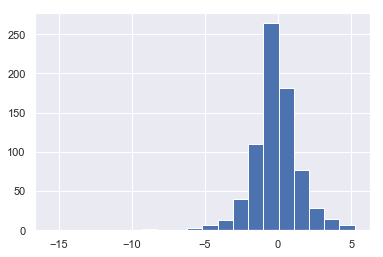

In [78]:
df.Difference.hist(bins=20)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


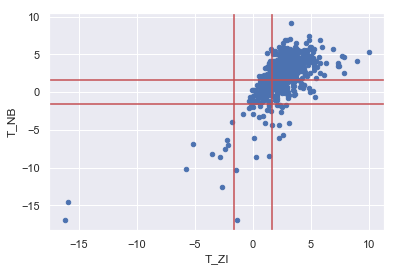

In [79]:
df.plot.scatter(x='T_ZI', y='T_NB')
plt.axvline(x=1.645, c="r")
plt.axvline(x=-1.645, c="r")
plt.axhline(y=1.645, c="r")
plt.axhline(y=-1.645, c="r")
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)
plt.savefig('hemato_ttests_all.png')

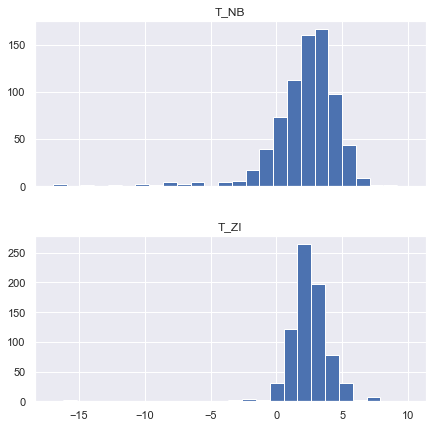

In [80]:
df.hist(column=['T_ZI', 'T_NB'], bins=25, figsize=(7, 7), sharex=True, layout=(2, 1))
plt.savefig('hemato_dropout_tstats.png')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/home/oscar/anaconda3/envs/scvienv/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1554: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                       inf
Date:                Mon, 15 Apr 2019   Prob (F-statistic):                nan
Time:                        12:58:46   Log-Likelihood:                -1470.6
No. Observations:                 750   AIC:                             2943.
Df Residuals:                     749   BIC:                             2948.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7190      0.018     39.174      0.000       0.683       0.755
==============================================================================
Omnibus:                      222.814   Durbin-Watson:                   1.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1058.659
Skew:                           1.276   Prob(JB):                    1.30e-230
Kurtosis:                       8.231   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

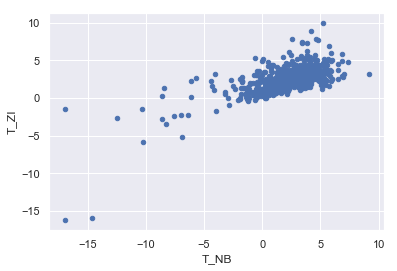

In [81]:
import statsmodels.api as sm

df.plot.scatter(x='T_NB', y='T_ZI')

mdl = sm.OLS(df.T_ZI.values, df.T_NB.values, hasconst=True).fit()
mdl.summary()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


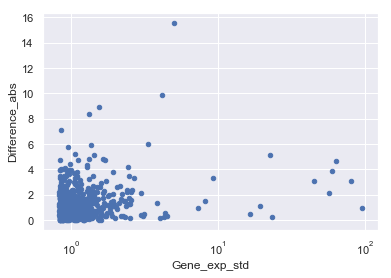

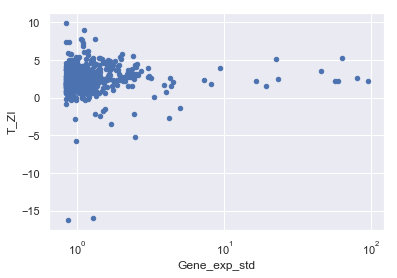

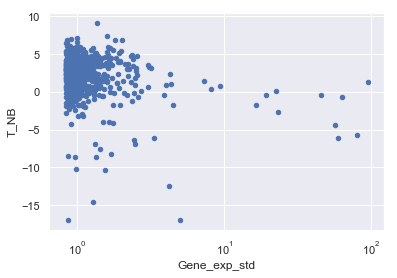

In [82]:
df.plot.scatter(x='Gene_exp_std', y='Difference_abs', logx=True)
df.plot.scatter(x='Gene_exp_std', y='T_ZI', logx=True)
# df.plot.scatter(x='Gene_exp_std', y='T_ZI_abs', logx=True)
df.plot.scatter(x='Gene_exp_std', y='T_NB', logx=True)
# df.plot.scatter(x='Gene_exp_std', y='T_NB_abs', logx=True)

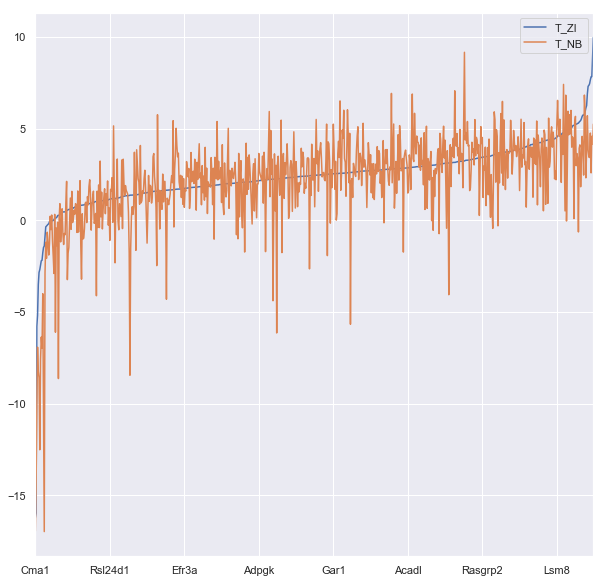

In [83]:
df.loc[:, ['T_ZI', 'T_NB']].plot(figsize=(10, 10))
plt.show()

In [84]:
df.sort_values('Difference_abs').tail(15)

,T_ZI,Pval_ZI,T_NB,Pval_NB,T_ZI_abs,T_NB_abs,Difference,Difference_abs,Gene_exp_std,Gene_exp_mean,...,Diff_gene_exp_mean_nb_mean_9,Corr_diff_gene_exp_mean_dropout_nb_9,dropout_zi_min_9,dropout_zi_max_9,dropout_zi_mean9,dropout_zi_std9,dropout_nb_min_9,dropout_nb_max_9,dropout_nb_mean9,dropout_nb_std9
Cd74,-3.506454,0.006656,-8.250007,1.729593e-05,3.506454,8.250007,-4.743552,4.743552,1.696075,0.139691,...,0.139500,-0.113165,0.258585,5.162525,3.104964,0.855771,-1.437180,0.408291,-0.216047,0.292309
Cyfip2,8.927729,0.000009,4.158338,2.453767e-03,8.927729,4.158338,4.769391,4.769391,1.113641,0.617281,...,0.617451,0.330411,-8.734782,-1.756291,-4.112098,1.521774,-0.512274,1.149522,0.117966,0.276779
H2-Ab1,-2.183437,0.056855,-6.974853,6.503009e-05,2.183437,6.974853,-4.791416,4.791416,1.321967,0.113048,...,0.113036,0.055131,-0.334585,3.683625,2.063606,0.539510,-0.639456,0.547045,0.076638,0.200296
Fkbp1a,4.872486,0.000880,-0.036105,9.719868e-01,4.872486,0.036105,4.836381,4.836381,1.662914,0.865538,...,0.865302,0.288897,-7.885124,1.869344,-1.827441,2.593281,-0.796294,0.736206,0.042483,0.168388
Hba-a1,5.182448,0.000577,0.094022,9.271516e-01,5.182448,0.094022,5.088426,5.088426,22.613040,5.256474,...,5.251504,0.200831,-6.258216,4.999280,1.392886,2.076894,-1.301706,0.754303,0.009466,0.337704
Cpa3,-2.439517,0.037394,-7.583295,3.384948e-05,2.439517,7.583295,-5.143778,5.143778,1.434888,0.170568,...,0.170855,0.044159,0.323871,6.977990,2.735625,1.389530,-0.634160,0.676641,0.045197,0.234346
Ccne1,7.827254,0.000026,2.587053,2.935503e-02,7.827254,2.587053,5.240201,5.240201,1.067562,0.452191,...,0.452048,0.521206,-7.628072,0.740322,-2.191116,2.039731,-0.479909,1.341289,0.342872,0.217176
Pf4,-2.842015,0.019339,-8.592240,1.245595e-05,2.842015,8.592240,-5.750226,5.750226,0.960772,0.077440,...,0.077752,-0.090442,1.444908,7.017407,3.668567,1.117464,-1.294244,0.599668,-0.451370,0.277026
Cenpf,3.238253,0.010187,9.163841,7.364785e-06,3.238253,9.163841,-5.925588,5.925588,1.367695,0.755229,...,0.755424,0.149256,-9.535063,-2.126517,-4.754604,1.304563,-0.892211,0.981214,0.048040,0.328351
H2-Aa,0.117135,0.909326,-6.101923,1.788268e-04,0.117135,6.101923,-5.984788,5.984788,3.326930,0.281374,...,0.281286,0.262922,-0.180815,4.077422,2.272765,0.730388,-0.534215,1.232295,0.294545,0.313386


In [85]:
df[['T_ZI', 'T_NB', 'Difference_abs']]

,T_ZI,T_NB,Difference_abs
Cma1,-16.220795,-16.945250,0.724455
Tpsb2,-15.962718,-14.588494,1.374224
Retnlg,-5.780826,-10.227230,4.446403
H2-Eb1,-5.180734,-6.919985,1.739252
Cd74,-3.506454,-8.250007,4.743552
Pf4,-2.842015,-8.592240,5.750226
Prss34,-2.689086,-12.514994,9.825909
Cpa3,-2.439517,-7.583295,5.143778
Mcpt8,-2.204751,-6.368269,4.163518
H2-Ab1,-2.183437,-6.974853,4.791416


# Experiments

In [86]:
%matplotlib inline
import torch
import pandas as pd

In [87]:
df = pd.read_csv('gene_specific_study/hemato_gene_stats_completed.csv', sep='\t', index_col=0)
df.head()

,T_ZI,Pval_ZI,T_NB,Pval_NB,T_ZI_abs,T_NB_abs,Difference,Difference_abs,Gene_exp_std,Gene_exp_mean,...,Diff_gene_exp_mean_nb_mean_9,Corr_diff_gene_exp_mean_dropout_nb_9,dropout_zi_min_9,dropout_zi_max_9,dropout_zi_mean9,dropout_zi_std9,dropout_nb_min_9,dropout_nb_max_9,dropout_nb_mean9,dropout_nb_std9
Cma1,-16.220795,5.707579e-08,-16.945250,3.895790e-08,16.220795,16.945250,-0.724455,0.724455,0.871287,0.023157,...,0.023232,-0.011868,2.289726,7.645750,4.482274,1.033548,-0.844542,0.324000,-0.074574,0.184743
Tpsb2,-15.962718,6.564842e-08,-14.588494,1.436046e-07,15.962718,14.588494,1.374224,1.374224,1.278214,0.020667,...,0.020733,-0.003063,2.386234,7.617198,4.443755,0.760009,-0.642779,0.771758,-0.022058,0.202581
Retnlg,-5.780826,2.657901e-04,-10.227230,2.966967e-06,5.780826,10.227230,-4.446403,4.446403,0.983650,0.057022,...,0.057069,0.042355,0.906264,6.739472,3.485796,0.916557,-0.791424,1.013313,0.166361,0.256748
H2-Eb1,-5.180734,5.787809e-04,-6.919985,6.911334e-05,5.180734,6.919985,-1.739252,1.739252,2.477435,0.191235,...,0.191136,-0.059419,0.254439,6.189434,3.381543,1.028832,-0.746610,0.365286,-0.034032,0.145481
Cd74,-3.506454,6.655617e-03,-8.250007,1.729593e-05,3.506454,8.250007,-4.743552,4.743552,1.696075,0.139691,...,0.139500,-0.113165,0.258585,5.162525,3.104964,0.855771,-1.437180,0.408291,-0.216047,0.292309


## Training ZI VAE

In [111]:
zi_vae = VAE(my_dataset.nb_genes, n_batch=my_dataset.n_batches * use_batches, dropout_rate=0.2,
                 reconstruction_loss='zinb', n_hidden=20)
my_zi_trainer = UnsupervisedTrainer(zi_vae,
                                    my_dataset,
                                    train_size=0.8,
                                    use_cuda=use_cuda,
                                    kl=1, verbose=verbose, frequency=10,
#                                     early_stopping_kwargs=early_stopping_kwargs
                                   )
my_zi_trainer.train(n_epochs=n_epochs, lr=lr, eps=0.01)



training:   0%|          | 0/120 [00:00<?, ?it/s]

training:   1%|          | 1/120 [00:00<00:18,  6.33it/s]

training:   2%|▏         | 2/120 [00:00<00:19,  6.16it/s]

training:   2%|▎         | 3/120 [00:00<00:18,  6.17it/s]

training:   3%|▎         | 4/120 [00:00<00:18,  6.19it/s]

training:   4%|▍         | 5/120 [00:00<00:18,  6.18it/s]

training:   5%|▌         | 6/120 [00:00<00:18,  6.14it/s]

training:   6%|▌         | 7/120 [00:01<00:18,  6.14it/s]

training:   7%|▋         | 8/120 [00:01<00:18,  6.07it/s]

training:   8%|▊         | 9/120 [00:01<00:18,  6.11it/s]

training:   8%|▊         | 10/120 [00:01<00:20,  5.41it/s]

training:   9%|▉         | 11/120 [00:01<00:19,  5.57it/s]

training:  10%|█         | 12/120 [00:02<00:20,  5.30it/s]

training:  11%|█         | 13/120 [00:02<00:20,  5.21it/s]

training:  12%|█▏        | 14/120 [00:02<00:19,  5.50it/s]

training:  12%|█▎        | 15/120 [00:02<00:18,  5.73it/s]

training:  13%|█▎        | 16/120 [00:02<00:17,  5.88it/

In [112]:
# Get gene expression counts

In [113]:
latent, batch, labels = my_zi_trainer.train_set.sequential().get_latent()
latent_tsne, _ = my_zi_trainer.train_set.apply_t_sne(latent, n_samples=None)
train_indices = my_zi_trainer.train_set.indices
x_train = my_zi_trainer.train_set.gene_dataset.X[train_indices]

# Get imputed px_scale & dropout
imp_scales, imp_dropouts = [], []
with torch.no_grad():
    for tensors in my_zi_trainer.train_set.sequential():
        sample_batch, _, _, batch_index, labels = tensors
        px_scale, _, _, px_dropout = my_zi_trainer.model.inference(sample_batch, batch_index=batch_index, n_samples=1)[0:4]
        imp_dropouts += [np.array(px_dropout.cpu())]
        imp_scales += [np.array(px_scale.cpu())]
imp_scales = np.concatenate(imp_scales)
imp_dropouts = np.concatenate(imp_dropouts)

## Individual Gene Study

In [114]:
selected = np.random.permutation(len(x_train))[:1000]

In [115]:
df

,T_ZI,Pval_ZI,T_NB,Pval_NB,T_ZI_abs,T_NB_abs,Difference,Difference_abs,Gene_exp_std,Gene_exp_mean,...,Diff_gene_exp_mean_nb_mean_9,Corr_diff_gene_exp_mean_dropout_nb_9,dropout_zi_min_9,dropout_zi_max_9,dropout_zi_mean9,dropout_zi_std9,dropout_nb_min_9,dropout_nb_max_9,dropout_nb_mean9,dropout_nb_std9
Cma1,-16.220795,5.707579e-08,-16.945250,3.895790e-08,16.220795,16.945250,-0.724455,0.724455,0.871287,0.023157,...,0.023232,-0.011868,2.289726,7.645750,4.482274,1.033548,-0.844542,0.324000,-0.074574,0.184743
Tpsb2,-15.962718,6.564842e-08,-14.588494,1.436046e-07,15.962718,14.588494,1.374224,1.374224,1.278214,0.020667,...,0.020733,-0.003063,2.386234,7.617198,4.443755,0.760009,-0.642779,0.771758,-0.022058,0.202581
Retnlg,-5.780826,2.657901e-04,-10.227230,2.966967e-06,5.780826,10.227230,-4.446403,4.446403,0.983650,0.057022,...,0.057069,0.042355,0.906264,6.739472,3.485796,0.916557,-0.791424,1.013313,0.166361,0.256748
H2-Eb1,-5.180734,5.787809e-04,-6.919985,6.911334e-05,5.180734,6.919985,-1.739252,1.739252,2.477435,0.191235,...,0.191136,-0.059419,0.254439,6.189434,3.381543,1.028832,-0.746610,0.365286,-0.034032,0.145481
Cd74,-3.506454,6.655617e-03,-8.250007,1.729593e-05,3.506454,8.250007,-4.743552,4.743552,1.696075,0.139691,...,0.139500,-0.113165,0.258585,5.162525,3.104964,0.855771,-1.437180,0.408291,-0.216047,0.292309
Pf4,-2.842015,1.933948e-02,-8.592240,1.245595e-05,2.842015,8.592240,-5.750226,5.750226,0.960772,0.077440,...,0.077752,-0.090442,1.444908,7.017407,3.668567,1.117464,-1.294244,0.599668,-0.451370,0.277026
Prss34,-2.689086,2.483369e-02,-12.514994,5.378866e-07,2.689086,12.514994,-9.825909,9.825909,4.185876,0.166833,...,0.167048,-0.020109,2.492807,7.188663,4.634111,0.875098,-0.614173,0.664570,-0.019202,0.216858
Cpa3,-2.439517,3.739424e-02,-7.583295,3.384948e-05,2.439517,7.583295,-5.143778,5.143778,1.434888,0.170568,...,0.170855,0.044159,0.323871,6.977990,2.735625,1.389530,-0.634160,0.676641,0.045197,0.234346
Mcpt8,-2.204751,5.491341e-02,-6.368269,1.300409e-04,2.204751,6.368269,-4.163518,4.163518,2.426541,0.102839,...,0.102982,0.086217,0.834582,7.031962,3.379541,1.266852,-0.414123,1.949478,0.268991,0.346316
H2-Ab1,-2.183437,5.685518e-02,-6.974853,6.503009e-05,2.183437,6.974853,-4.791416,4.791416,1.321967,0.113048,...,0.113036,0.055131,-0.334585,3.683625,2.063606,0.539510,-0.639456,0.547045,0.076638,0.200296


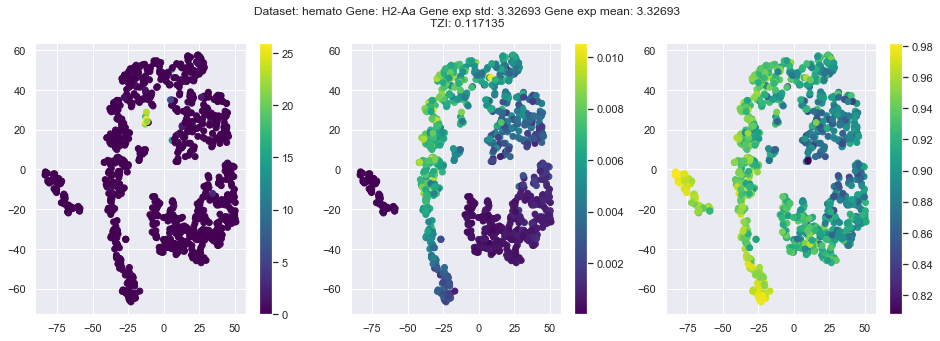

In [118]:
gene_name = 'H2-Aa'
gene_idx = my_dataset._gene_idx([gene_name])[0]
gene_info = df.loc[gene_name]
# my_zi_trainer.train_set.show_t_sne(n_samples=10, latent=latent_tsne, labels=gene_expression, color_by='scalar')

sample_latent = latent[selected, :]
sample_latent_tsne = latent_tsne[selected, :]
sample_gene_expression = x_train[selected, gene_idx]
sample_imp_scale = imp_scales[selected, gene_idx]
sample_imp_dropout = imp_dropouts[selected, gene_idx]
sample_imp_dropout = 1.0 / (1.0 + np.exp(-sample_imp_dropout))

fig, axes = plt.subplots(ncols=3, figsize=(16, 5))

plt.suptitle('Dataset: {} Gene: {} Gene exp std: {:4g} Gene exp mean: {:4g}\nTZI: {:4g}'.format(
    dataset_name, gene_name, gene_info.Gene_exp_std, gene_info.Gene_exp_std, gene_info.T_ZI
))
plt.sca(axes[0])
plt.scatter(sample_latent_tsne[:, 0], sample_latent_tsne[:, 1], 
            c=sample_gene_expression, 
            cmap='viridis')
cbar = plt.colorbar()
plt.sca(axes[1])
plt.scatter(sample_latent_tsne[:, 0], sample_latent_tsne[:, 1], 
            c=sample_imp_scale, 
            cmap='viridis')
cbar = plt.colorbar()
plt.sca(axes[2])
plt.scatter(sample_latent_tsne[:, 0], sample_latent_tsne[:, 1], 
            c=sample_imp_dropout, 
            cmap='viridis')
cbar = plt.colorbar()

plt.savefig('gene_specific_study/HEMATO/20comp/tzi_{:1f}_gene_{}.png'.format(gene_info.T_ZI, gene_name))

## All genes Study

In [ ]:
# my_zi_trainer.train_set.show_t_sne(n_samples=10, latent=latent_tsne, labels=gene_expression, color_by='scalar')

sample_latent = latent[selected, :]
sample_latent_tsne = latent_tsne[selected, :]
for gene_idx, gene_name in enumerate(tqdm(my_dataset.gene_names)):
    sample_gene_expression = x_train[selected, gene_idx]
    sample_imp_scale = imp_scales[selected, gene_idx]
    sample_imp_dropout = imp_dropouts[selected, gene_idx]
    sample_imp_dropout = 1.0 / (1.0 + np.exp(-sample_imp_dropout))

    fig, axes = plt.subplots(ncols=3, figsize=(16, 5))
    gene_info = df.loc[gene_name]
    plt.suptitle('Dataset: {} Gene: {} Gene exp std: {:4g} Gene exp mean: {:4g}\nTZI: {:4g}'.format(
        dataset_name, gene_name, gene_info.Gene_exp_std, gene_info.Gene_exp_std, gene_info.T_ZI
    ))
    plt.sca(axes[0])
    plt.scatter(sample_latent_tsne[:, 0], sample_latent_tsne[:, 1], 
                c=sample_gene_expression, 
                cmap='viridis')
    cbar = plt.colorbar()
    plt.sca(axes[1])
    plt.scatter(sample_latent_tsne[:, 0], sample_latent_tsne[:, 1], 
                c=sample_imp_scale, 
                cmap='viridis')
    cbar = plt.colorbar()
    plt.sca(axes[2])
    plt.scatter(sample_latent_tsne[:, 0], sample_latent_tsne[:, 1], 
                c=sample_imp_dropout, 
                cmap='viridis')
    cbar = plt.colorbar()

    plt.savefig('gene_specific_study/HEMATO/20comp/tzi_{:1f}_gene_{}.png'.format(gene_info.T_ZI, gene_name))
    plt.close()